# Regression Analysis

You can specify a build number in the **current_build** variable to generate a report for a specific build version, otherwise it will default to the most recent 7.0.1 build.

In [45]:
release="7.0.1"
current_build=""

In [46]:
import requests
import json

import math
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly
from plotly.offline import *
from plotly.subplots import make_subplots

In [47]:
def run_query(query, host="172.23.99.54", port=8093, username="Administrator", password="password", param=None):
    url_base = f"http://{host}:{port}/query/service"
    params = {'statement': query, 'scan_consistency': 'REQUEST_PLUS'}
    if param:
        params.update(param)
    response = requests.get(url=url_base, params=params, auth = requests.auth.HTTPBasicAuth(username, password))
    return response.json()

In [48]:
if type(current_build) != type("") or len(str(current_build)) != 4:
    query_current_weekly_build = f'SELECT raw `build` FROM server WHERE `build` < "{release}." GROUP BY `build` HAVING sum(totalCount) > 10000 ORDER BY `build` DESC LIMIT 1'
    current_result = run_query(query=query_current_weekly_build, param={'$version': f'"{release}-0000"'})
    current_build = current_result['results'][0].split("-", 1)[1]

In [49]:
query_last_weekly_build = f'SELECT raw `build` FROM server WHERE `build` <= $version AND `build` > "{release}" GROUP BY `build` HAVING sum(totalCount) > 10000 ORDER BY `build` DESC LIMIT 2'
result = run_query(query=query_last_weekly_build, param={'$version': f'"{release}-{current_build}"'})
weekly_builds = result['results']

## Top 25 Jobs with the Most Failures

In [50]:
owners = {
    "analytics":"bob1",
    "backup":"bob2",
    "nserv":"bob3",
    "durability":"bob4",
    "security":"bob5",
    "obj":"bob6",
    "p0":"bob7",
    "xdcr":"bob8",
    "P0":"bob9",
    "2i":"bob10",
    "transaction":"bob11",
    "ephemeral":"bob12",
    "query":"bob13",
    "fts":"bob15",
    "tools":"bob16",
    "ce":"bob17",
    "eventing":"bob18",
    "n1ql":"bob19",
    "nsserver":"bob20",
    "upgrade":"bob21",
    "nutshell":"bob22",
    "plasma":"bob23",
    "lcb":"bob24",
    "sync":"bob25",
    "geo":"bob26",
    "epeng":"bob27",
    "bkrs":"bob28",
    "ent":"bob29"
}

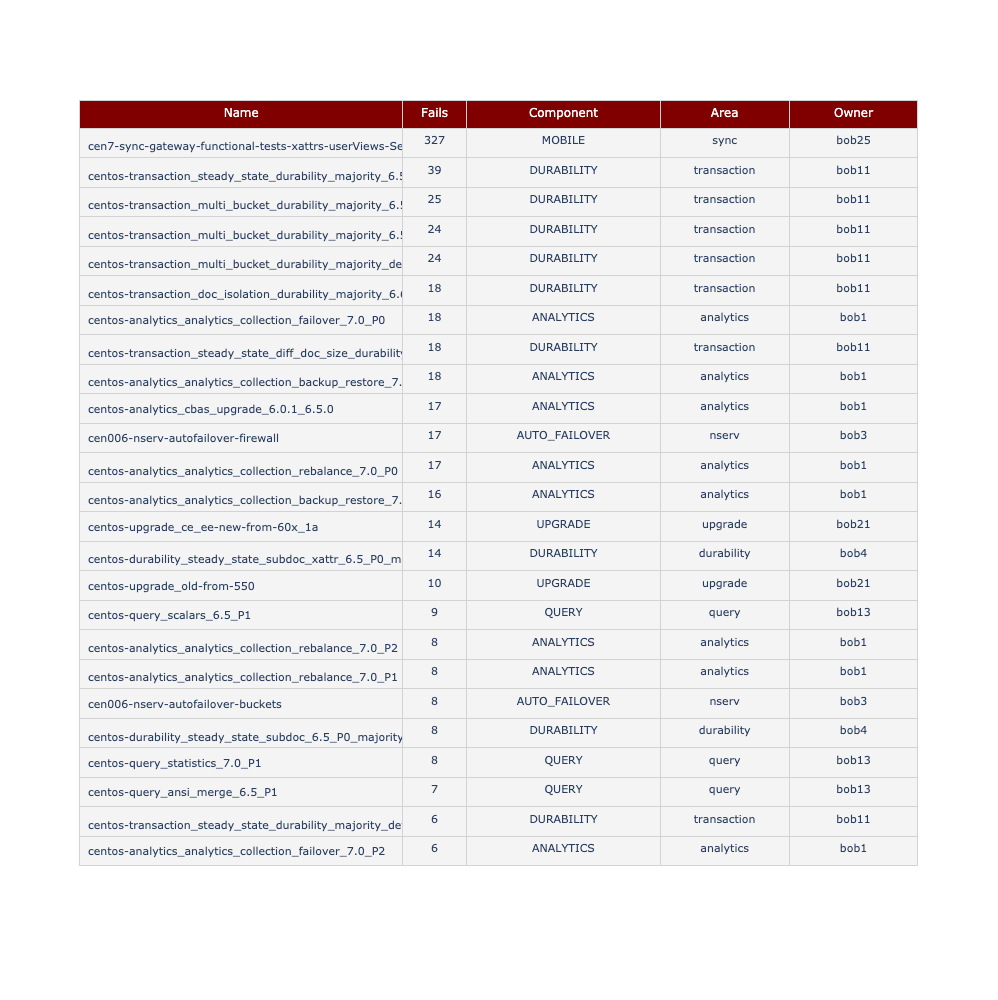

In [51]:
#top 25 failures

top_25_query = 'select url || to_string(build_id) as `joburl`,name,failCount,component,SPLIT(REPLACE(REPLACE(REPLACE(SPLIT(name,"-")[1], "os_certify_ce_", ""), "ipv6_", ""), "os_certify_", ""), "_")[0] as area,result from server where `build`=$version and lower(os)="centos" order by failCount desc limit 25'
top_25_failures = run_query(query=top_25_query, param={'$version': f'"{release}-{current_build}"'})

data_top_t25 = pd.DataFrame(top_25_failures['results'])

owners_data = []
for area in data_top_t25.area:
    owners_data.append(owners[f'{area}'])

        
def make_clickable(url, name):
    return '<a href="{}"target="_blank">{}</a>'.format(url,name)

data_top_t25['job'] = data_top_t25.apply(lambda x: make_clickable(x['joburl'], x['name']), axis=1)
data_top_t25 = data_top_t25.drop('joburl', axis=1)


table_t25_failures = go.Figure(data=[go.Table(
    columnwidth=(0.5, 0.10, 0.3, 0.2, 0.2),
    header = dict(values = ["Name", "Fails", "Component", "Area", "Owner"], fill_color = 'maroon', font=dict(color='white'), line_color='lightgray'),
    cells = dict(values = [data_top_t25.job, data_top_t25.failCount, data_top_t25.component, data_top_t25.area, owners_data], align=['left', 'center', 'center', 'center', 'center'], line_color='lightgray', fill_color='#F4F4F4', font=dict(size=11))
)])

table_t25_failures.update_layout(height=1000)

table_t25_failures.show()

## Over 50 Failures

In [52]:
# 50+ failures

failures_50_query = f"""WITH components AS (
    SELECT RAW component
    FROM server
    WHERE LOWER(os)="centos"
        AND `build`="{weekly_builds[0]}"
    GROUP BY component
    HAVING SUM(failCount) > 50 )
SELECT component, SPLIT(REPLACE(REPLACE(REPLACE(SPLIT(name,"-")[1], "os_certify_ce_", ""), "ipv6_", ""), "os_certify_", ""), "_")[0] as area,
       SUM(CASE WHEN `build` = "{weekly_builds[0]}" THEN failCount END) AS CurrentFailed,
       SUM(CASE WHEN `build` = "{weekly_builds[1]}" THEN failCount END) AS LastFailed,
       SUM(CASE WHEN `build` = "{weekly_builds[0]}" THEN totalCount END) AS CurrentCount
FROM server
WHERE LOWER(os)="centos"
    AND `build`IN ["{weekly_builds[0]}","{weekly_builds[1]}"]
    AND component IN components
GROUP BY component, SPLIT(REPLACE(REPLACE(REPLACE(SPLIT(name,"-")[1], "os_certify_ce_", ""), "ipv6_", ""), "os_certify_", ""), "_")[0]
HAVING SUM(CASE WHEN `build` = "{weekly_builds[0]}" THEN failCount END) > 0 or SUM(CASE WHEN `build` = "{weekly_builds[1]}" THEN failCount END) > 0
ORDER BY component, area"""

failures_50 = run_query(query=failures_50_query, param={'$version': f'"{release}-{current_build}"'})
sortdf50 = failures_50['results']

data_table_50 = pd.DataFrame(sortdf50)

IndexError: list index out of range

In [ ]:
if sortdf50 != []:
    component_data = []
    total_data = {}

    sorted_dt50_components = sorted(list(set(data_table_50.component)))
    for compo in sorted_dt50_components:
        component_data.append([])
        total_data[f'{compo}'] = [0, 0]

    for i in sortdf50:
        i_component = i['component']
        index = sorted_dt50_components.index(i_component)
        total_data[f'{i_component}'][0] = total_data[f'{i_component}'][0] + i['CurrentFailed']
        total_data[f'{i_component}'][1] = total_data[f'{i_component}'][1] + i['LastFailed']
        component_data[index].append(f"<b>{i['area']}</b><br>Now: {i['CurrentFailed']}<br>Last: {i['LastFailed']}")

    ind = 0
    for each in component_data:
        each.insert(0, f"<b>Total</b><br>Now: {total_data[f'{sorted_dt50_components[ind]}'][0]}<br>Last: {total_data[f'{sorted_dt50_components[ind]}'][1]}")
        ind = ind + 1

    df_cdata = pd.DataFrame(component_data)
    df_cdata = df_cdata.fillna("")
    df_cdata = df_cdata.T

    final_data = []
    for element in range(0, len(df_cdata.columns)):
        final_data.append(df_cdata.iloc[:, element])



Below is a table and a bar graph that display information about the components with 50 or more failures across all areas and compares the information to that of the previous weekly build.

In [ ]:
if sortdf50 != []:
    cell50_colors = ['#F4F4F4', '#F4F4F4', '#F4F4F4']
    delta50_colors = []
    delta50_text = []

    for i in range(0, len(data_table_50)):
        delta_i = data_table_50.LastFailed.iloc[i] - data_table_50.CurrentFailed.iloc[i]
        if delta_i < 0:
            delta50_colors.append('#FFBAAB')
            delta50_text.append(str(abs(delta_i)) + ' more failures' if delta_i < -1 else str(abs(delta_i)) + ' more failure')
        elif delta_i == 0:
            delta50_colors.append("#F4F4F4")
            delta50_text.append("No Change")
        else:
            delta50_colors.append('#8BE9A3')
            delta50_text.append(str(delta_i) + ' less  failures' if delta_i > 1 else str(delta_i) + ' less failure')

    cell50_colors.append(delta50_colors)

    old_table_50 = go.Figure(data=[go.Table(
        header = dict(values=["Component", "Break-Up", f'Fails in {current_build}', f'Delta from {weekly_builds[1]}'], fill_color="maroon", font=dict(color="white")),
        cells = dict(values=[data_table_50.component, data_table_50.area, data_table_50.CurrentFailed, delta50_text], fill_color=cell50_colors, line_color="lightgray")
    )])

    table_50 = go.Figure(data=[go.Table(
        header = dict(values=sorted_dt50_components, fill_color="maroon", font=dict(color="white")),
        cells = dict(values=final_data, fill_color="#F4F4F4", line_color="lightgray", height=50)
    )])

    old_table_50.update_layout(height=700, title=f"Areas in {weekly_builds[0]} with Over 50 Failures and Comparison with {weekly_builds[1]} (Table)")
    old_table_50.show()
else:
    print("No components over 50 failures")

Hover over a bar for more information. You can click on each area's name to the right of the bar chart to toggle the data from that area, or double click on an area to isolate that area. You can double click on a hidden area to toggle all data back to shown.

In [ ]:
newSet = []
for item in sortdf50:
    current = item.pop('CurrentFailed')
    last = item.pop('LastFailed')
    currentFails = {"fails": current, "ver": "current"}
    lastFails = {"fails": last, "ver": "last"}
    newSet.append({**lastFails, **item})
    newSet.append({**currentFails, **item})
    
df50 = pd.DataFrame(newSet)

all_fig = px.bar(df50, y=df50.fails, x=df50.ver, color=df50.area, facet_col=df50.component, facet_col_wrap=8)

all_fig.for_each_annotation(lambda a: a.update(text=a.text.replace("component=", "")))
all_fig.update_xaxes(title_text='')
all_fig.update_yaxes(gridcolor='lightsteelblue', gridwidth=2)
all_fig.update_layout(height=600*math.ceil(len(set(df50.component))/8), title=f"Areas in {weekly_builds[0]} with Over 50 Failures and Comparison with {weekly_builds[1]} (Graph)", hoverlabel=dict(bgcolor="white"))

all_fig.show()

## Total Failures for Each Component

This displays the amount of failures from each component, along with the change from the previous weekly build.

In [ ]:
#query_last_weekly_build = f'SELECT raw `build` FROM server WHERE `build` <= $version GROUP BY `build` HAVING sum(totalCount) > 10000 ORDER BY `build` DESC LIMIT 2'
total_fails_query = 'select component,sum(failCount) as TotalFailed from server where lower(os)="centos" and `build`=$version group by component  order by component'

#result = run_query(query=query_last_weekly_build, param={'$version': f'"{release}-{current_build}"'})
#weekly_builds = result['results']
total_fails = run_query(query=total_fails_query, param={'$version': f'"{release}-{current_build}"'})
last_total_fails = run_query(query=total_fails_query, param={'$version': f'"{str(weekly_builds[1])}"'})

weekly_builds[1] = str(weekly_builds[1]).split("-", 1)

ldata_f = pd.DataFrame(last_total_fails['results'])
data_f = pd.DataFrame(total_fails['results'])

In [ ]:
cell_colors = ['#F4F4F4', '#F4F4F4']
delta_colors = []
delta_text = []

for i in range(0, len(data_f)):
    delta_i = ldata_f.TotalFailed.iloc[i] - data_f.TotalFailed.iloc[i]
    if delta_i < 0:
        delta_colors.append('#FFBAAB')
        delta_text.append(str(abs(delta_i)) + ' more failures' if delta_i < -1 else str(abs(delta_i)) + ' more failure')
    elif delta_i == 0:
        delta_colors.append("#F4F4F4")
        delta_text.append("No Change")
    else:
        delta_colors.append('#8BE9A3')
        delta_text.append(str(delta_i) + ' less  failures' if delta_i > 1 else str(delta_i) + ' less failure')
cell_colors.append(delta_colors)

fig_total_fails = go.Figure(data=[go.Table(
    header=dict(values = ['Component', f'Failed in {current_build}', f'Delta from {weekly_builds[1][1]}'], fill_color='maroon', line_color='lightgray', font=dict(color='white')),
    cells=dict(values = [data_f.component, data_f.TotalFailed, delta_text], fill_color=cell_colors, line_color='lightgray')
)])

fig_total_fails.update_layout(height=1000)

query_last_weekly_build = f'SELECT raw `build` FROM server WHERE `build` <= $version GROUP BY `build` HAVING sum(totalCount) > 10000 ORDER BY `build` DESC LIMIT 2'
result = run_query(query=query_last_weekly_build, param={'$version': f'"{release}-{current_build}"'})
weekly_builds = result['results']

fig_total_fails.show()